<a href="https://colab.research.google.com/github/Angelvj/TFG/blob/main/code/jupyter/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import numpy as np
import tensorflow as tf
import keras as k
import nibabel as nib
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, MaxPool3D, GlobalAveragePooling3D
from keras.utils import to_categorical
import matplotlib.pyplot as plt

import time
import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_PATH = '/content/drive/My Drive/Machine learning/data'

else: 
  DATA_PATH = '../../data'

def load_image(filename):    
    """
    
    Parameters
    ----------
    filename : str
        relative path to de image

    Returns
    -------
    img : numpy ndarray
        array containing the image
        
    """
    img = nib.load(filename)
    img = np.asarray(img.dataobj)
    img = np.expand_dims(img, axis=3)
    return img


def load_images_from_dir(dirname):
    """
    
    Parameters
    ----------
    dirname : str
        name of the directory containing images.

    Returns
    -------
    imgs : numpy ndarray
        array containing all of the images in the folder.

    """
    imgs = []

    for filename in tqdm(glob.glob(dirname + '/*.nii')):
        imgs.append(load_image(filename))
        
    imgs = np.stack(imgs)
    return imgs

def load_data(dirs_dict, categorical = False):
    """
    
    Parameters
    ----------
    dirs_dict : dictionary
        dictionary containing data folders name, and the label for the images
        on each forlder.

    Returns
    -------
    x : numpy ndarray
        array containing the images.
    y : numpy ndarray
        array containig the label of each image.

    """
    first = True
    for key, value in dirs_dict.items():
        if first:
            X = load_images_from_dir(value)
            y = np.full((X.shape[0]), key, dtype=np.uint8)
            first = False
        else:
            X_current = load_images_from_dir(value)
            X = np.concatenate((X, X_current))
            y = np.concatenate((y, np.full((X_current.shape[0]), key, dtype=np.uint8)))
            
    if categorical:
        y = k.utils.to_categorical(y)
    
    return X, y

def impute_nan_values(imgs, inplace=True):
    # Replace nan values with 0
    return np.nan_to_num(imgs, copy= not inplace)

# Load PET images with labels
print('\n --- Loading PET data --- \n')
time.sleep(0.5)
X, y = load_data({0: DATA_PATH + "/ppNOR/PET", 
                  1: DATA_PATH + "/ppAD/PET",
                  2: DATA_PATH + "/ppMCI/PET"})

# Separate into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

impute_nan_values(X_train)
impute_nan_values(X_test)


print('\n --- PET data loaded --- \n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 --- Loading PET data --- 



100%|██████████| 111/111 [00:00<00:00, 219.32it/s]



 --- PET data loaded --- 



In [7]:
# Loading MRI images, its a bit different process because they are separated into 
# gray and white matter


def load_mri_data(dict_dirs, categorical = False):
    pass


# Pruebo a cargar una imagen cualquiera
image = load_image(DATA_PATH + "/ppNOR/MRI/greyMatter/m0wrp1ADNI_005_S_0223_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20070809183352346_S19963_I66520.nii")

print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(121, 145, 121, 1)


In [8]:
def learning_curve(hist):
    history_dict = hist.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()

    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy','Validation accuracy'])
    plt.show()

In [9]:
def cross_validate(model, x_train, y_train, num_folds, opt, batch_size, epochs, verbose=0, show_history=False):

    # Creamos un objeto kfold, especificando el número de segmentos que queremos utilizar,
    # además utilizamos shuffle true, para que los num_folds conjuntos disjuntos se seleccionen
    # de forma aleatoria, evitando de esta forma problemas que podría haber si los datos
    # estuvieran ordenados siguiendo una cierta distribución

    skfold = StratifiedKFold(n_splits = num_folds, shuffle=True)

    model.compile(loss = k.losses.categorical_crossentropy, optimizer=opt,
                metrics = ['accuracy'])

    initial_weights = model.get_weights()

    acc_per_fold = []
    loss_per_fold = []

    fold_no = 1

    for kfold_train, kfold_test in skfold.split(x_train, y_train):

        # En cada fold, comenzamos con los pesos iniciales. Tratamos de que las 5
        # folds sean lo más independientes posible.
        model.set_weights(initial_weights)

        print('------------------------------------------------------------------------')
        print(f'Entrenando para el fold {fold_no} ...')


        print('Clases en train: ', np.sum(k.utils.to_categorical(y_train[kfold_train]), axis=0))
        print('Clases en validación: ', np.sum(k.utils.to_categorical(y_train[kfold_test]), axis=0))

        history = model.fit(x_train[kfold_train], 
                            k.utils.to_categorical(y_train[kfold_train]), 
                            batch_size= batch_size,
                            epochs=epochs, verbose = verbose, 
                            validation_data = (x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]))
                            )

        if show_history:
            # Mostramos la evolución en cada fold
            learning_curve(history)

        # Número de épocas que se han utilizado
        print('Numero de épocas realizadas: ', len(history.history['loss']))

        # Calculamos la bondad del modelo para el fold reservado para testing
        scores = model.evaluate(x_train[kfold_test], k.utils.to_categorical(y_train[kfold_test]), verbose=0)

        # Vamos guardando el accuracy y pérdida para cada fold
        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        print(f'Resultado para el fold {fold_no}: {model.metrics_names[0]} de {scores[0]}; {model.metrics_names[1]} de {scores[1]*100}%')

        fold_no += 1

    # ==  Mostramos los valores medios == 
    print('------------------------------------------------------------------------')
    print('Resultados por cada fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Media de los resultados para todos los folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)}')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 79, 95, 68, 1)]   0         
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 77, 93, 66, 64)    1792      
_________________________________________________________________
max_pooling3d_57 (MaxPooling (None, 38, 46, 33, 64)    0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 38, 46, 33, 64)    256       
_________________________________________________________________
conv3d_64 (Conv3D)           (None, 36, 44, 31, 64)    110656    
_________________________________________________________________
max_pooling3d_58 (MaxPooling (None, 18, 22, 15, 64)    0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 18, 22, 15, 64)    256   

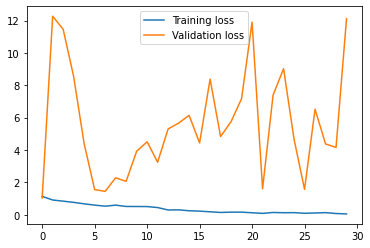

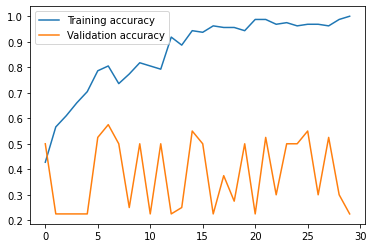

In [47]:
# CNN MODELS

# Model configuration
sample_shape = (79,95,68,1)
no_classes = 3

# First very basic model:
'''
Problemas de este modelo:

 - A pesar de ser muy pequeño sufre de overfitting (bajo error en training pero
 alto en validación/validación cruzada) --> realmente no hay tantísimo, podría
 ser peor.

 - Muy poco profundo, por lo que probablemente las características que es capaz
 de extraer de las imágenes no sean excesivamente ricas. 

'''
# model = Sequential()
# model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
# model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(Conv3D(32, kernel_size=(3,3,3), activation='relu', kernel_initializer='he_uniform'))
# model.add(MaxPooling3D(pool_size=(2,2,2)))
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(no_classes, activation='softmax'))
# model.summary()


# Second model: little deeper
def get_model(width=79, height=95, depth=68):
    """Build a 3D convolutional neural network model."""

    inputs = k.Input((width, height, depth, 1))

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = MaxPool3D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling3D()(x)
    x = Dense(units=512, activation="relu")(x)
    x = Dropout(0.3)(x)

    outputs = Dense(units=3, activation="softmax")(x)

    # Define the model.
    model = k.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=79, height=95, depth=68)
model.summary()


# Compile the model 
model.compile(loss='categorical_crossentropy', optimizer=k.optimizers.Adam(), metrics=['accuracy'])

# Fit model to data
history = model.fit(X_train, k.utils.to_categorical(y_train), batch_size=16, 
                    epochs=30, verbose=1, validation_split=0.2)

learning_curve(history)

# cross_validate(model, X_train, y_train, 5, k.optimizers.Adam(lr=0.0001), 16, 12, 
#                verbose = 1, show_history = True)